In [51]:
%load_ext autoreload
%autoreload 2


import numpy as np
import sys

import matplotlib.pyplot as plt  
import seaborn as sns
import figures as figs
import calculations
from types import SimpleNamespace
import pandas as pd
import pandasdmx as sdmx

from pandasdmx import Request
import pandas as pd
import matplotlib.pyplot as plt

# Ploting jacobians wrt ptilde
from matplotlib.ticker import FormatStrFormatter

import gc  # For garbage collection
import itertools


from seaborn import set_palette
from matplotlib import rc
plt.style.use('seaborn-v0_8-white')
set_palette("colorblind")
rc('font',**{'family':'serif','serif': ['Palatino']})
rc('text',usetex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

# Should make insure text size in latex mode
# plt.rcParams.update({
#     "text.latex.preamble": r"\usepackage{palatino} \normalsize"
# })

from IHANKModel import IHANKModelClass

from pandasdmx import Request
import pandas as pd
import matplotlib.pyplot as plt





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Inflation for intro 

In [56]:
new_fig = True

2025-07-19 16:59:16,661 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-19 16:59:16,788 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-19 16:59:16,893 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-19 16:59:17,088 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


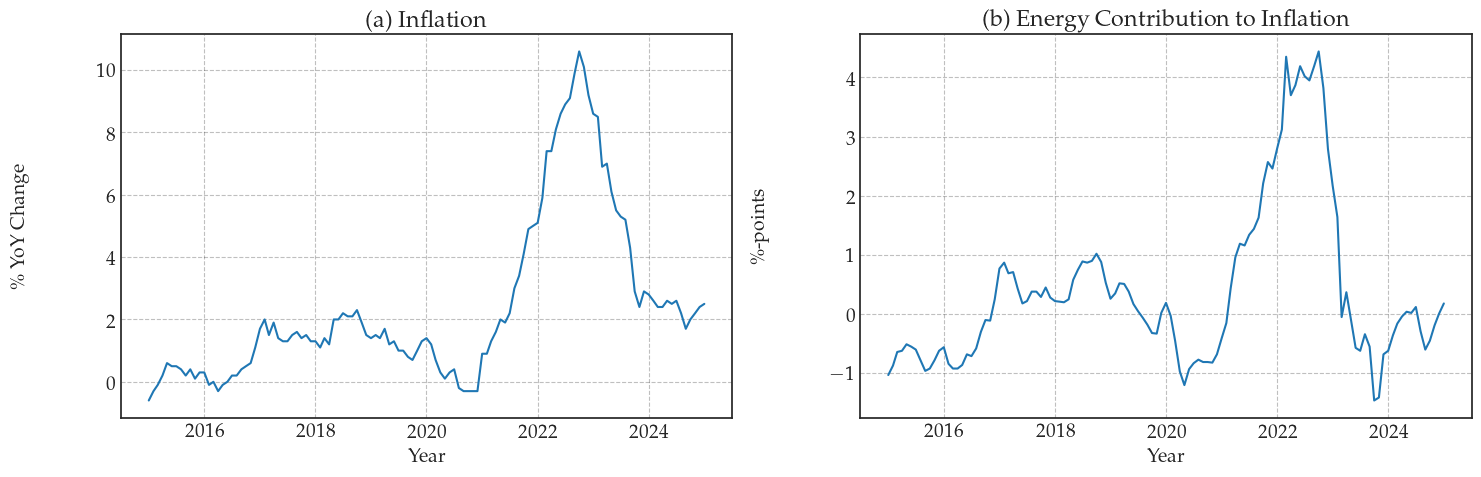

In [59]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from pandasdmx import Request

estat = Request('ESTAT')

# --- 1. Inflation data ---
inflation_resp = estat.data(
    resource_id='PRC_HICP_MANR',
    key={'geo': 'EA', 'coicop': 'CP00', 'freq': 'M'},
    params={'startPeriod': '2015-01', 'endPeriod': '2025-01'}
)
df_inflation = inflation_resp.to_pandas().reset_index()
df_inflation['TIME_PERIOD'] = pd.to_datetime(df_inflation['TIME_PERIOD'])
df_inflation['value'] = df_inflation['value'].astype(float)

# --- 2. Energy share by quintile ---
energy_resp = estat.data(
    resource_id='ICW_AFF_01',
    key={
        'geo': 'EU',
        'coicop': ['CP00', 'CP045', 'CP0722'],
        'quant_inc': ['QU1', 'QU2', 'QU3', 'QU4', 'QU5']
    },
    params={'startPeriod': '2015', 'endPeriod': '2015'}
)
df_energy = energy_resp.to_pandas().reset_index()
quintile_order = ['QU1', 'QU2', 'QU3', 'QU4', 'QU5']
df_energy['quant_rank'] = df_energy['quant_inc'].apply(lambda q: quintile_order.index(q) + 1)
df_pivot = df_energy.pivot(index='quant_inc', columns='coicop', values='value').reset_index()
df_pivot['energy_total'] = df_pivot['CP045'] + df_pivot['CP0722']
df_pivot['energy_share'] = df_pivot['energy_total'] / df_pivot['CP00'] * 100
df_pivot['quant_rank'] = df_pivot['quant_inc'].apply(lambda q: quintile_order.index(q) + 1)
df_pivot = df_pivot.sort_values('quant_rank')

# --- 3. Energy prices ---
prices_resp = estat.data(
    resource_id='PRC_HICP_MANR',
    key={'geo': 'EA', 'coicop': 'NRG', 'freq': 'M'},
    params={'startPeriod': '2015-01', 'endPeriod': '2025-01'}
)
df_prices = prices_resp.to_pandas().reset_index()
df_prices['TIME_PERIOD'] = pd.to_datetime(df_prices['TIME_PERIOD'])
df_prices['value'] = df_prices['value'].astype(float)

# --- Additional data: Energy contribution to inflation ---
contrib_resp = estat.data(
    resource_id='PRC_HICP_CTRB',
    key={'geo': 'EA', 'coicop': 'NRG', 'freq': 'M'},
    params={'startPeriod': '2015-01', 'endPeriod': '2025-01'}
)
df_contrib = contrib_resp.to_pandas().reset_index()
df_contrib['TIME_PERIOD'] = pd.to_datetime(df_contrib['TIME_PERIOD'])
df_contrib['value'] = df_contrib['value'].astype(float)

# --- Modify Subplot 1 to include energy contribution ---
fig = plt.figure(figsize=(15, 5))

# Subplot 1: Inflation
ax1 = fig.add_subplot(121)
ax1.plot(df_inflation['TIME_PERIOD'], df_inflation['value'], color='tab:blue', label='Overall Inflation')
# ax1.plot(df_contrib['TIME_PERIOD'], df_contrib['value'], color='tab:red', linestyle='--', label='Energy Contribution')
ax1.set_title('(a) Inflation')
ax1.set_xlabel('Year')
ax1.set_ylabel(r'\% YoY Change')
ax1.yaxis.set_label_coords(-0.15, 0.5)
# ax1.legend()

# # Subplot 2: Energy expenditure share
# ax2 = fig.add_subplot(133)
# ax2.bar(df_pivot['quant_rank'], df_pivot['energy_share'], color='tab:blue')
# ax2.set_xticks([1, 2, 3, 4, 5])
# ax2.set_xticklabels([1, 2, 3, 4, 5])
# ax2.set_title('(c) Energy Expenditure Share')
# ax2.set_xlabel('Income Quintile')
# ax2.set_ylabel(r'\% of Expenditure')
# ax2.yaxis.set_label_coords(-0.15, 0.5)

# Subplot 3: Energy prices
ax3 = fig.add_subplot(122)
# ax3.plot(df_prices['TIME_PERIOD'], df_prices['value'], color='tab:blue')
ax3.plot(df_contrib['TIME_PERIOD'], df_contrib['value'], color='tab:blue',  label='Energy Contribution')
ax3.set_title('(b) Energy Contribution to Inflation')
ax3.set_xlabel('Year')
ax3.set_ylabel(r'\%-points ')
ax3.yaxis.set_label_coords(-0.15, 0.5)

# Final layout
fig.subplots_adjust(left=0.08, right=0.98, wspace=0.3)
fig.tight_layout()
if new_fig:  fig.savefig('plots/intro_figure.png', dpi=300, bbox_inches='tight')



# Non-tradables share

In [5]:
# Dictionaries 
coicops = [
    'CP011', 'CP012', 'CP021', 'CP022', 'CP031', 'CP032',
    # 'CP041', 'CP042',
     'CP043', 'CP044', 'CP045',
    'CP051', 'CP052', 'CP053', 'CP054', 'CP055', 'CP056',
    'CP061', 'CP062', 'CP063',
    'CP071', 'CP072', 'CP073',
    'CP081', 'CP082', 'CP083',
    'CP091', 'CP092', 'CP093', 'CP094', 'CP095', 'CP096',
    'CP111', 'CP112',
    'CP121', 'CP122', 'CP123', 'CP124', 'CP125', 'CP126', 'CP127'
]

# Rent Actual CP041
# Imputed rents for housing CP042 (Not tradable)

coicop_tradable = {
    'CP011': True, 'CP012': True, 'CP021': True, 'CP022': True,
    'CP031': True, 'CP032': True,
    # 'CP041': False, 'CP042': False,
     'CP043': False, 'CP044': False, 'CP045': True,
    'CP051': True, 'CP052': True, 'CP053': True, 'CP054': True, 'CP055': True, 'CP056': True,
    'CP061': True, 'CP062': False, 'CP063': False,
    'CP071': True, 'CP072': False, 'CP073': False,
    'CP081': False, 'CP082': True, 'CP083': False,
    'CP091': True, 'CP092': True, 'CP093': True, 'CP094': False, 'CP095': True, 'CP096': True,
    'CP111': False, 'CP112': False,
    'CP121': False, 'CP122': False, 'CP123': False, 'CP124': False, 'CP125': False, 'CP126': False, 'CP127': False
}

# Year and countries 
year = '2015'
geos = [

    'AT',  # Austria
    'BE',  # Belgium
    'CY',  # Cyprus
    'EE',  # Estonia
    'FI',  # Finland
    'FR',  # France
    'DE',  # Germany
    'EL',  # Greece
    'IE',  # Ireland
    'IT',  # Italy
    'LV',  # Latvia
    'LT',  # Lithuania
    'LU',  # Luxembourg
    'MT',  # Malta
    'NL',  # Netherlands
    'PT',  # Portugal
    'SK',  # Slovakia
    'SI',  # Slovenia
    'ES'   # Spain
]

country_names = {
    'AT': 'Austria',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'HR': 'Croatia',
    'CY': 'Cyprus',
    'CZ': 'Czechia',
    'DK': 'Denmark',
    'EE': 'Estonia',
    'FI': 'Finland',
    'FR': 'France',
    'DE': 'Germany',
    'GR': 'Greece',
    'HU': 'Hungary',
    'IE': 'Ireland',
    'IT': 'Italy',
    'LV': 'Latvia',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'MT': 'Malta',
    'NL': 'Netherlands',
    'PL': 'Poland',
    'PT': 'Portugal',
    'RO': 'Romania',
    'SK': 'Slovakia',
    'SI': 'Slovenia',
    'ES': 'Spain',
    'SE': 'Sweden'
}

# df_final['country_name'] = df_final['geo'].map(country_names)

In [20]:

# --- Step 1: Download data ---
data_list = []

for geo in geos:
    for coicop in coicops:
        try:
            data = estat.data(
                resource_id='HBS_STR_T223',
                key={'geo': geo, 'coicop': coicop},
                params={'startPeriod': year, 'endPeriod': year}
            )
            df = data.to_pandas().reset_index()
            df['coicop'] = coicop
            df['geo'] = geo
            data_list.append(df)
        except Exception as e:
            print(f"Error for {geo}-{coicop}: {e}")

# --- Step 2: Combine and filter ---
df_all = pd.concat(data_list, ignore_index=True)
df_all = df_all[df_all['quantile'].str.startswith('QUINTILE')]
df_all['quantile_num'] = df_all['quantile'].str.extract(r'QUINTILE(\d)').astype(int)
df_all['tradable'] = df_all['coicop'].map(coicop_tradable)

# --- Step 3: Aggregations ---

# Total spending
total = df_all.groupby(['geo', 'quantile_num'])['value'].sum().reset_index(name='total_value')

# Non-tradable spending
nontrad = df_all[~df_all['tradable']].groupby(['geo', 'quantile_num'])['value'].sum().reset_index(name='nontrad_value')

# Energy spending (CP045)
energy_df = df_all[df_all['coicop'] == 'CP045']
energy_grouped = energy_df.groupby(['geo', 'quantile_num'])['value'].sum().reset_index(name='energy_value')

# energy = energy_df.groupby(['geo', 'quantile_num'])['value'].sum().reset_index(name='energy_value')

# --- Step 4: Merge everything ---
df_merged = pd.merge(total, nontrad, on=['geo', 'quantile_num'], how='left')
df_merged = pd.merge(df_merged, energy_grouped, on=['geo', 'quantile_num'], how='left')


# # --- Step 5: Compute shares ---
df_merged['nontrad_value'] = df_merged['nontrad_value'].fillna(0)
df_merged['energy_value'] = df_merged['energy_value'].fillna(0)

df_merged['nontrad_share'] = (df_merged['nontrad_value'] / df_merged['total_value'])*100
df_merged['energy_share'] = (df_merged['energy_value'] / df_merged['total_value'])*100


2025-07-17 21:33:17,191 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 21:33:17,305 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 21:33:17,407 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 21:33:17,502 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 21:33:17,600 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 21:33:17,716 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 21:33:17,814 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 21:33:17,914 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 21:33:17,991 pandasdmx.reader.sdmxml 

In [16]:
# # --- Download top cut-off point data from ilc_di01 ---
# response = estat.data(
#     resource_id='ILC_DI01',
#     key={
#         'indic_il': 'TC',        # Top cut-off point
#         'quantile': ['QU1', 'QU2', 'QU3', 'QU4', 'QU5'],  # Income quintiles
#         'geo': geos              # use your list of countries
#     },
#     params={'startPeriod': '2015', 'endPeriod': '2015'}
# )

# # Convert to DataFrame
# income_df = response.to_pandas().reset_index()
# # income_df


# # # Clean and rename
# income_df['quantile_num'] = income_df['quantile'].str.extract(r'QU(\d)').astype(int)
# income_df = income_df[['geo', 'quantile_num', 'value']]
# income_df.rename(columns={'value': 'income'}, inplace=True)
# income_df

response = estat.data(
    resource_id='ILC_DI01',
    key={
        'indic_il': 'TC',  # Top cut-off point
        'quantile': ['D1', 'D3', 'D5', 'D7', 'D9'],
        'geo': geos
    },
    params={'startPeriod': '2015', 'endPeriod': '2015'}
)

# Convert and clean
income_df = response.to_pandas().reset_index()
income_df['quintile_num'] = income_df['quantile'].str.extract(r'D(\d)').astype(int)
income_df['quintile_num'] = income_df['quintile_num'].replace({
    1: 1,
    3: 2,
    5: 3,
    7: 4,
    9: 5
})
income_df = income_df[['geo', 'quintile_num', 'currency', 'value']]
income_df.rename(columns={'value': 'income', 'quintile_num':'quantile_num'}, inplace=True)
income_df = income_df[income_df['currency'] == 'EUR']


2025-07-17 21:30:48,408 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


In [21]:
df_final = pd.merge(
    df_merged,
    income_df[['geo', 'quantile_num', 'income']],
    on=['geo', 'quantile_num'],
    how='inner'
)# Merged 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


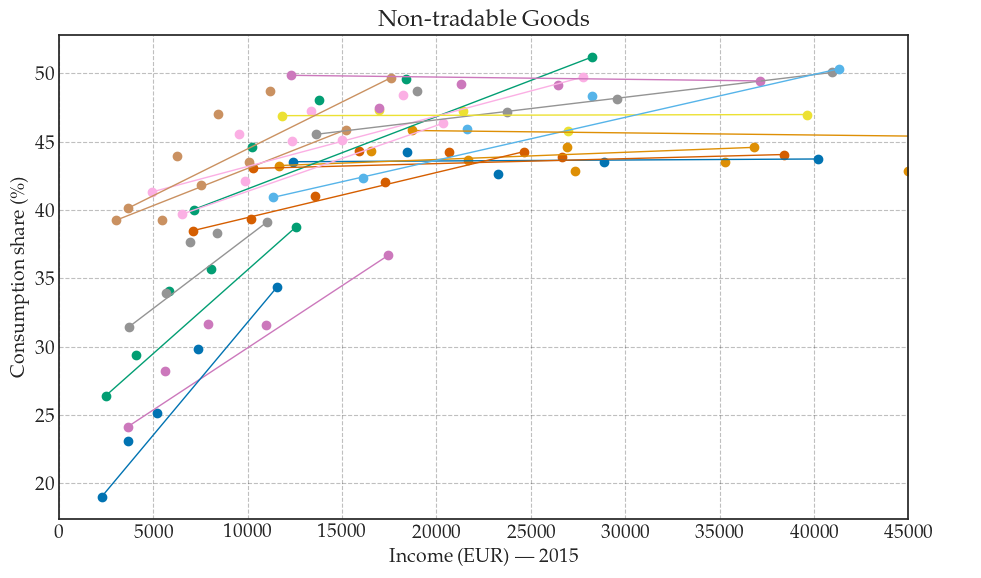

In [22]:


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

for geo in df_final['geo'].unique():
    country_data = df_final[df_final['geo'] == geo].sort_values('income')
    name = country_names.get(geo, geo)  # full name or fallback to code

    # Plot scatter points for quantiles
    ax.scatter(
        country_data['income'],
        country_data['nontrad_share'] ,
        # label=name
    )

    # Draw straight line from first to last point
    x_vals = [country_data['income'].iloc[0], country_data['income'].iloc[-1]]
    y_vals = [(country_data['nontrad_share'] ).iloc[0],
              (country_data['nontrad_share'] ).iloc[-1]]
    ax.plot(x_vals, y_vals, linestyle='-', linewidth=1)

# Set labels, limits, and legend
ax.set_xlim(0, 45000)
ax.set_xlabel('Income (EUR) — 2015')
ax.set_ylabel('Consumption share (\%)')
ax.set_title('Non-tradable Goods')
ax.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
# ax.set_xlabel('Top Cut-off Disposable Income (EUR) — 2015')
# ax.set_ylabel('Non-tradable consumption share (%)')
# ax.set_title('Non-tradable Consumption Shares by Income Quantile (EU, 2015)')

plt.tight_layout()
# fig.savefig('plots/nontradable_consumption_share_by_income_quantile.png', dpi=300, bbox_inches='tight')
# plt.show()


# Energy Share

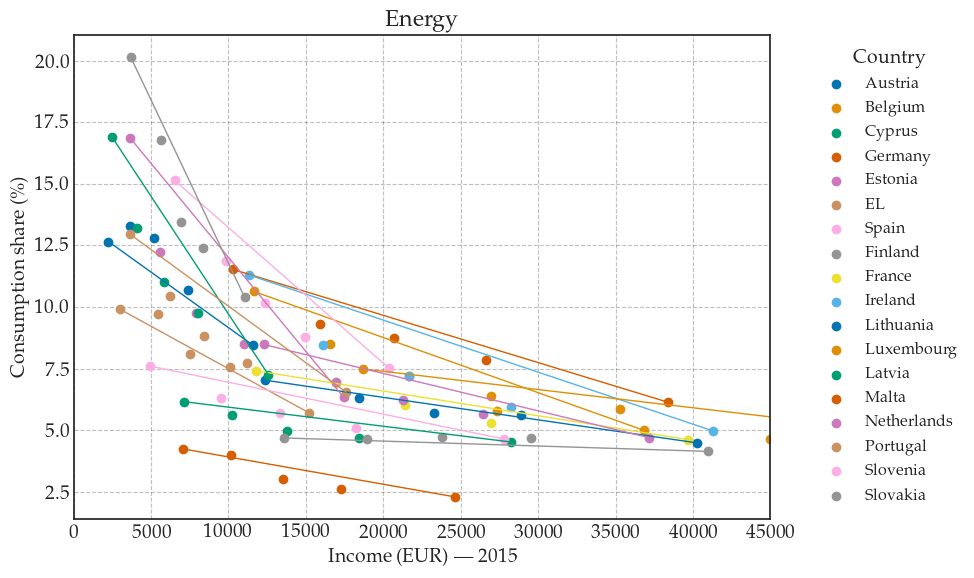

In [23]:

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

for geo in df_final['geo'].unique():
    country_data = df_final[df_final['geo'] == geo].sort_values('income')
    name = country_names.get(geo, geo)  # full name or fallback to code

    # Plot scatter points (quantiles)
    ax.scatter(
        country_data['income'],
        country_data['energy_share'] ,
        label=name
    )

    # Draw a single line from first to last point
    x_vals = [country_data['income'].iloc[0], country_data['income'].iloc[-1]]
    y_vals = [(country_data['energy_share'] ).iloc[0],
              (country_data['energy_share'] ).iloc[-1]]

    ax.plot(x_vals, y_vals, linestyle='-', linewidth=1)

# Set labels, limits, and legend
ax.set_xlim(0, 45000)
ax.set_xlabel('Income (EUR) — 2015')
ax.set_ylabel('Consumption share (\%)')
ax.set_title('Energy')
ax.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.tight_layout()

# fig.savefig('plots/energy_share_by_income_quantile.png', dpi=300, bbox_inches='tight')

# Averages

In [45]:

# --- Step 1: Download data ---
data_list = []

geos = ['EU27_2020']

for geo in geos:
    for coicop in coicops:
        try:
            data = estat.data(
                resource_id='HBS_STR_T223',
                key={'geo': geo, 'coicop': coicop},
                params={'startPeriod': year, 'endPeriod': year}
            )
            df = data.to_pandas().reset_index()
            df['coicop'] = coicop
            df['geo'] = geo
            data_list.append(df)
        except Exception as e:
            print(f"Error for {geo}-{coicop}: {e}")

# --- Step 2: Combine and filter ---
# df_all = pd.concat(data_list, ignore_index=True)
# df_all = df_all[df_all['quantile'].str.startswith('QUINTILE')]
# df_all['quantile_num'] = df_all['quantile'].str.extract(r'QUINTILE(\d)').astype(int)
# df_all['tradable'] = df_all['coicop'].map(coicop_tradable)

# --- Step 3: Aggregations ---

# # Total spending
# total = df_all.groupby(['geo', 'quantile_num'])['value'].sum().reset_index(name='total_value')

# # Non-tradable spending
# nontrad = df_all[~df_all['tradable']].groupby(['geo', 'quantile_num'])['value'].sum().reset_index(name='nontrad_value')

# # Energy spending (CP045)
# energy_df = df_all[df_all['coicop'] == 'CP045']
# energy_grouped = energy_df.groupby(['geo', 'quantile_num'])['value'].sum().reset_index(name='energy_value')

# # energy = energy_df.groupby(['geo', 'quantile_num'])['value'].sum().reset_index(name='energy_value')

# # --- Step 4: Merge everything ---
# df_merged = pd.merge(total, nontrad, on=['geo', 'quantile_num'], how='left')
# df_merged = pd.merge(df_merged, energy_grouped, on=['geo', 'quantile_num'], how='left')


# # # --- Step 5: Compute shares ---
# df_merged['nontrad_value'] = df_merged['nontrad_value'].fillna(0)
# df_merged['energy_value'] = df_merged['energy_value'].fillna(0)

# df_merged['nontrad_share'] = (df_merged['nontrad_value'] / df_merged['total_value'])*100
# df_merged['energy_share'] = (df_merged['energy_value'] / df_merged['total_value'])*100      

2025-07-17 22:00:20,133 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:20,225 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP011: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP012: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:20,336 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:20,427 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:20,519 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP021: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP022: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP031: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:20,608 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:20,699 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP032: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP043: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:21,072 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:21,163 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:21,262 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP044: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP045: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP051: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:21,387 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:21,496 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:21,592 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP052: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP053: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP054: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:21,691 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:21,794 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP055: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP056: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:21,910 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:21,990 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:22,075 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP061: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP062: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP063: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:22,171 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:22,270 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP071: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP072: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:22,435 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:22,532 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:22,618 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP073: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP081: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP082: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:22,698 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:22,789 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP083: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP091: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:22,959 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:23,059 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:23,141 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP092: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP093: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP094: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:23,245 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:23,339 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP095: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP096: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:23,484 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:23,576 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP111: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP112: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:23,690 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:23,781 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:23,877 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP121: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP122: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP123: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:24,010 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:24,095 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-07-17 22:00:24,177 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP124: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP125: 'list' object has no attribute 'reset_index'
Error for EU27_2020-CP126: 'list' object has no attribute 'reset_index'


2025-07-17 22:00:24,265 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


Error for EU27_2020-CP127: 'list' object has no attribute 'reset_index'


In [47]:
df_merged[geo == 'EU27_2020']

KeyError: True

In [26]:
data = estat.data(
                resource_id='HBS_STR_T223',
                key={'geo': 'EU27_2020', 'coicop': coicop},
                params={'startPeriod': year, 'endPeriod': year}
            )


2025-07-17 21:37:17,634 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


TypeError: 'DataMessage' object is not subscriptable

In [33]:
estat = Request('ESTAT')


coicop_code = 'CP011'  # Example COICOP code for food and non-alcoholic beverages

# --- 2. Energy share by quintile ---
df = estat.data(
    resource_id='HBS_STR_T223',
    key={
        'geo': 'EU27_2020',
        'coicop': coicop_code #'CP011',
    },
    params={'startPeriod': '2015', 'endPeriod': '2015'}
)


df = df.to_pandas().reset_index()
df.head()

2025-07-17 21:38:55,192 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


AttributeError: 'list' object has no attribute 'reset_index'